In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [2]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

In [3]:
tickerSymbol='AAPL'
data=yf.Ticker(tickerSymbol)
data

yfinance.Ticker object <AAPL>

In [4]:
prices=data.history(start='2021-01-01',end='2021-04-01').Close
returns=prices.pct_change().dropna()

returns

Date
2021-01-05 00:00:00-05:00    0.012364
2021-01-06 00:00:00-05:00   -0.033662
2021-01-07 00:00:00-05:00    0.034123
2021-01-08 00:00:00-05:00    0.008632
2021-01-11 00:00:00-05:00   -0.023249
2021-01-12 00:00:00-05:00   -0.001396
2021-01-13 00:00:00-05:00    0.016227
2021-01-14 00:00:00-05:00   -0.015127
2021-01-15 00:00:00-05:00   -0.013731
2021-01-19 00:00:00-05:00    0.005427
2021-01-20 00:00:00-05:00    0.032856
2021-01-21 00:00:00-05:00    0.036658
2021-01-22 00:00:00-05:00    0.016074
2021-01-25 00:00:00-05:00    0.027684
2021-01-26 00:00:00-05:00    0.001680
2021-01-27 00:00:00-05:00   -0.007684
2021-01-28 00:00:00-05:00   -0.034985
2021-01-29 00:00:00-05:00   -0.037420
2021-02-01 00:00:00-05:00    0.016520
2021-02-02 00:00:00-05:00    0.006337
2021-02-03 00:00:00-05:00   -0.007779
2021-02-04 00:00:00-05:00    0.025758
2021-02-05 00:00:00-05:00   -0.003098
2021-02-08 00:00:00-05:00    0.001097
2021-02-09 00:00:00-05:00   -0.006574
2021-02-10 00:00:00-05:00   -0.004559
2021-02

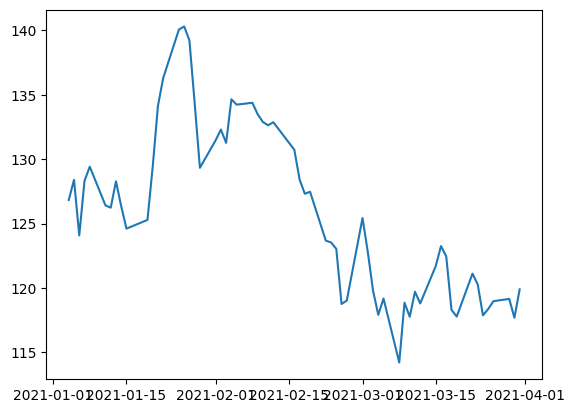

In [5]:
plt.plot(prices)
#Clearly not stationary

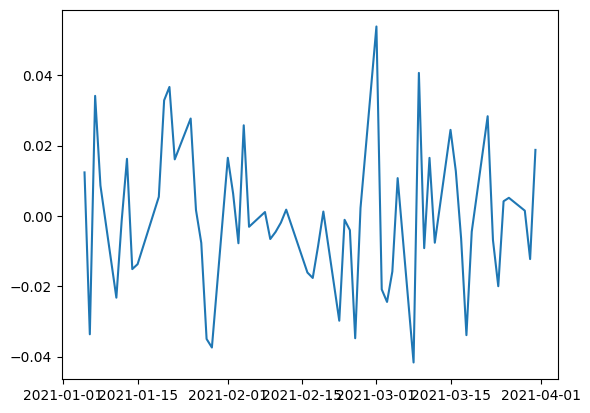

In [6]:
#We use returns since we require a stationary time series
plt.plot(returns)

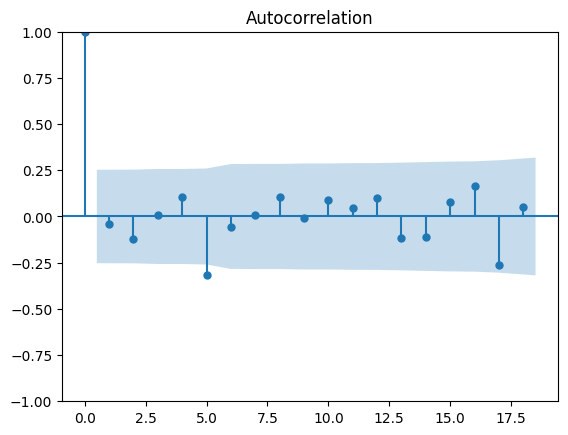

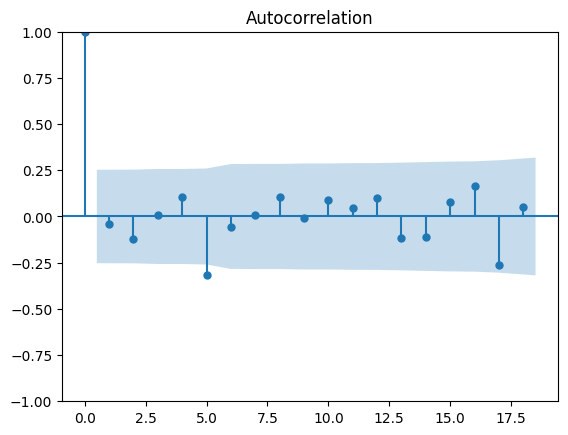

In [7]:
plot_acf(returns)

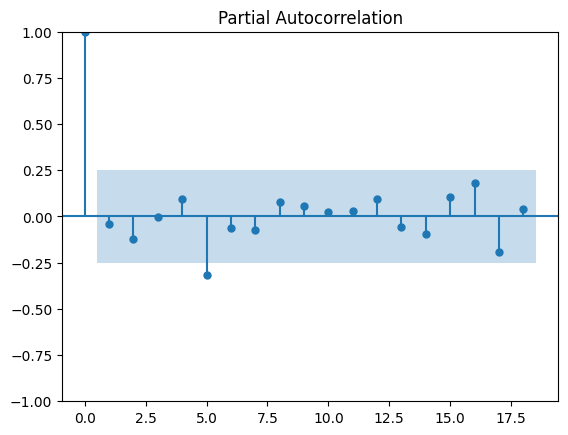

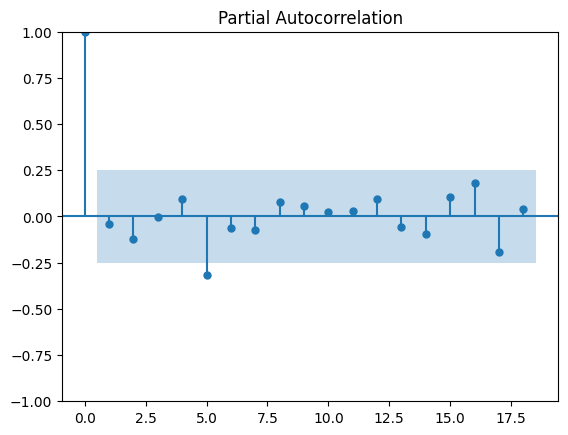

In [8]:
plot_pacf(returns)

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 27625.71it/s]


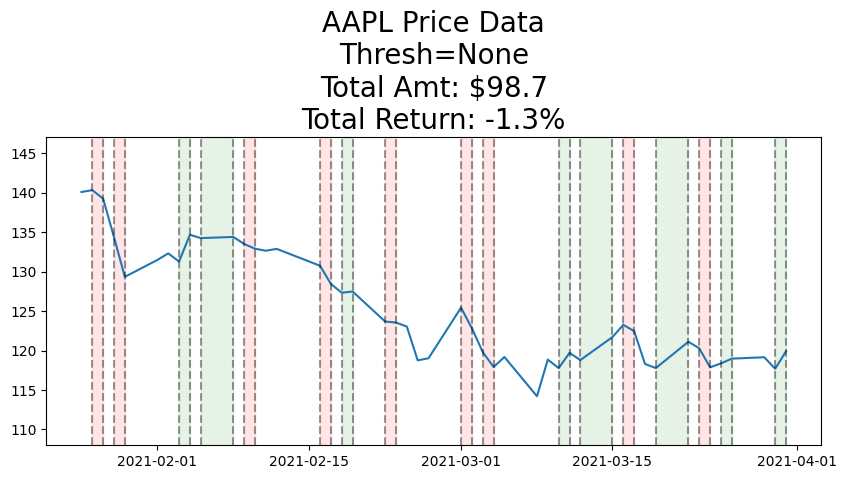

98.6983740581054

In [9]:
#This is random buying selling model
run_simulation(returns,prices,100,0.5,None,verbose=False)

In [10]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 57991.58it/s]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Avg: $95.19\nSD: $6.27')

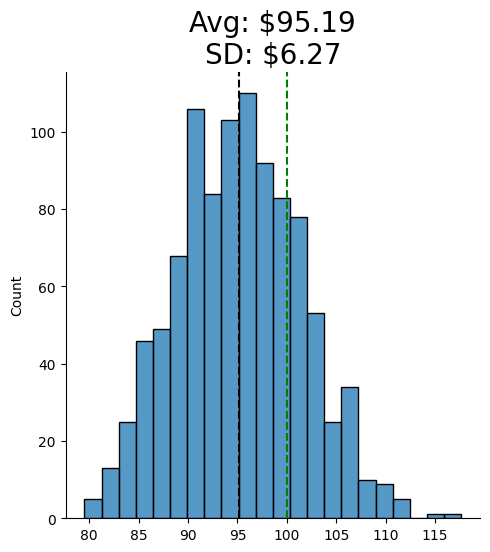

In [11]:
sns.displot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 37391.08it/s]


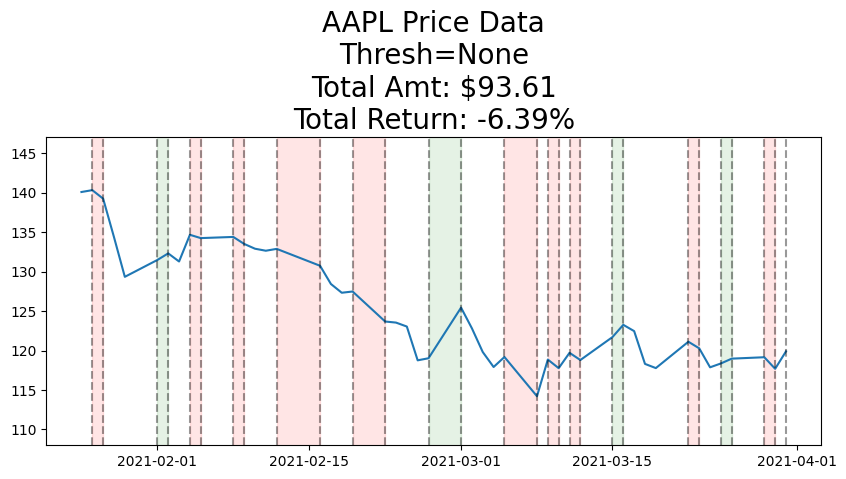

93.60988833390667

In [12]:
#Next Simulation-If last return was positive,buy and then sell the next day

run_simulation(returns,prices,100,'last',None,verbose=False)

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 36417.14it/s]


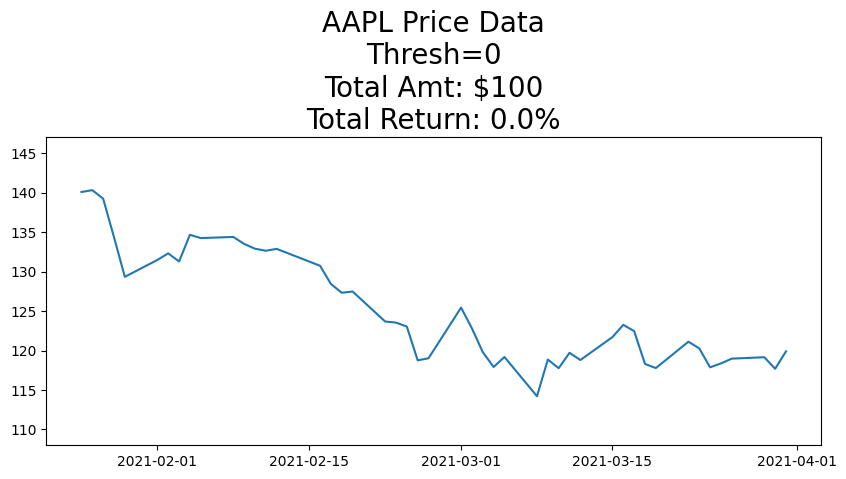

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 40388.94it/s]


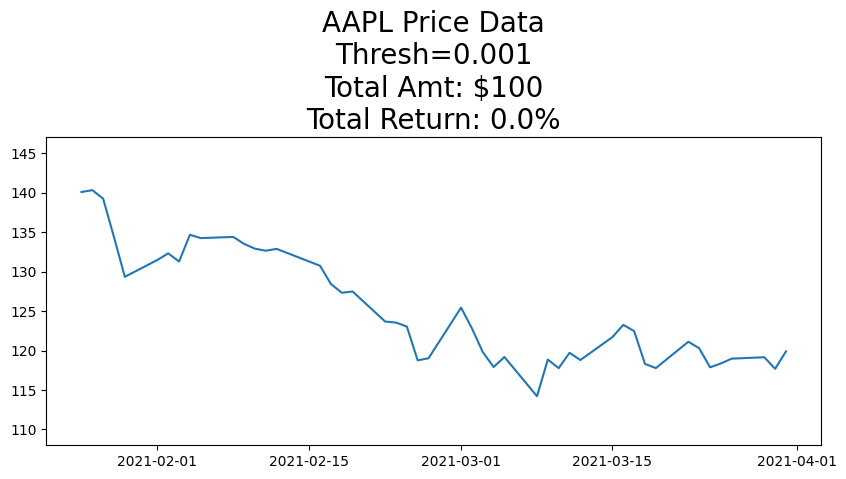

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 28398.29it/s]


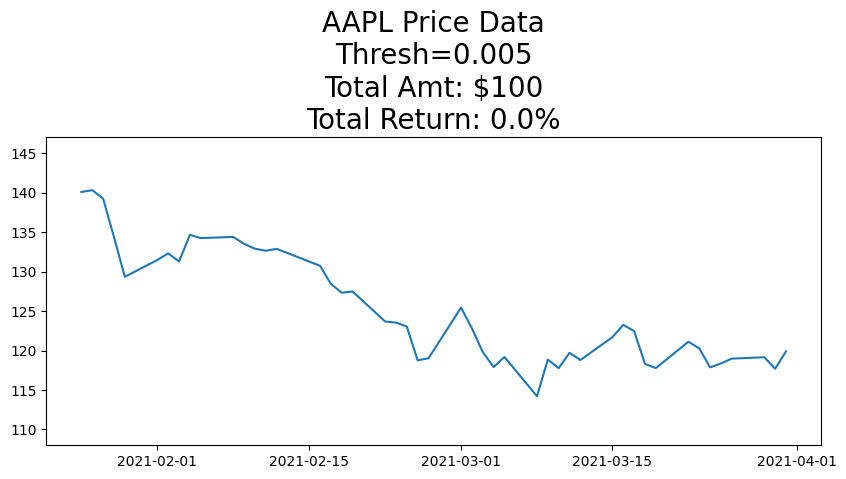

In [13]:
#Trying an AR(1) Model

for thresh in [0, 0.001, 0.005]:
    run_simulation(returns,prices,100,(1,0,0),thresh,verbose=False)

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 37153.47it/s]


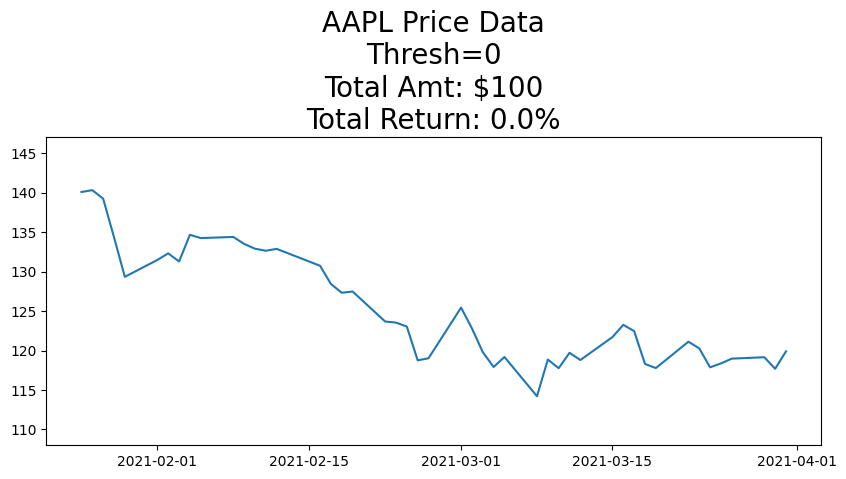

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 40773.03it/s]


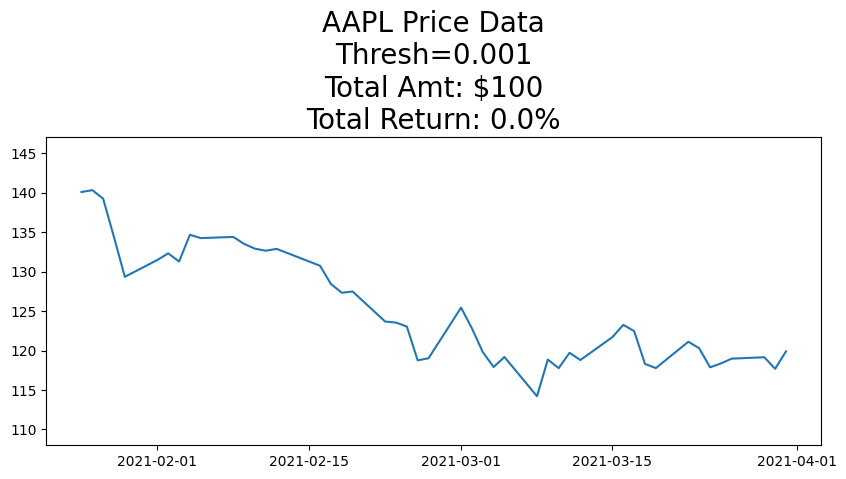

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 41217.26it/s]


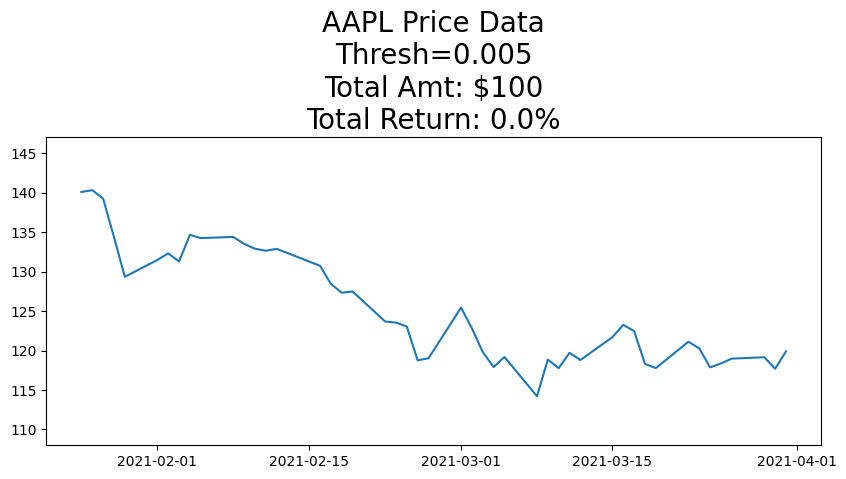

In [14]:
#Trying an AR(5) Model

for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,0), thresh, verbose=False)

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 37587.76it/s]


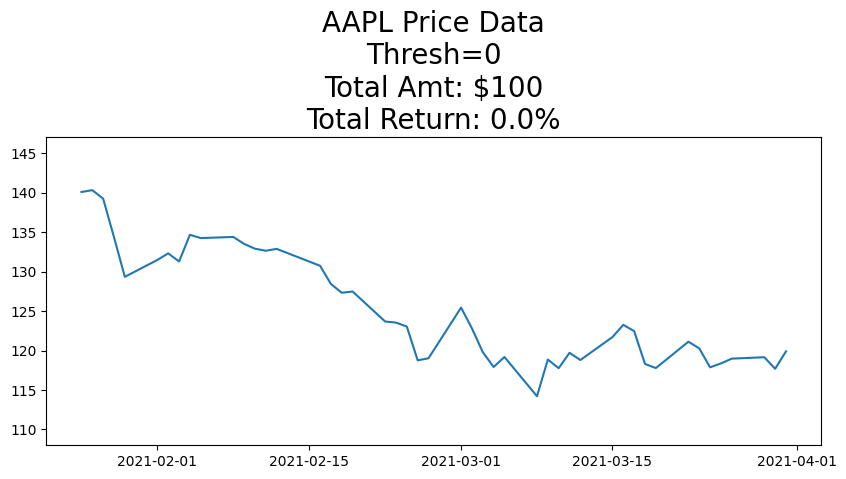

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 31701.94it/s]


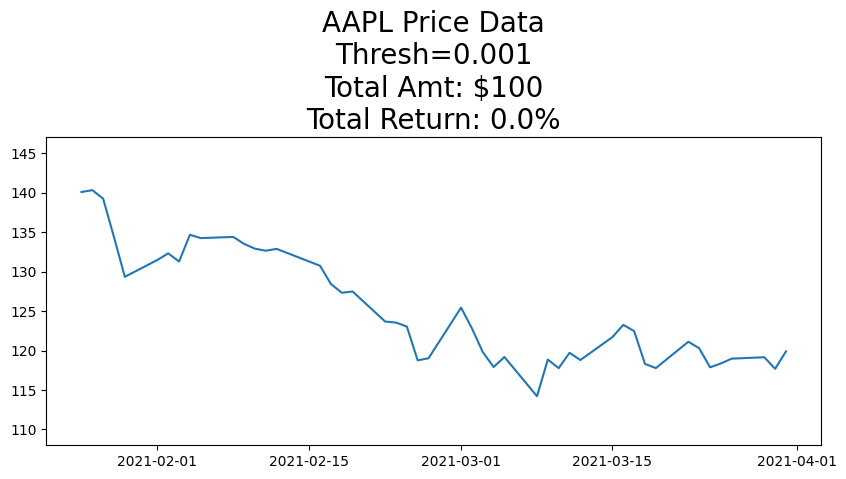

100%|████████████████████████████████████████| 46/46 [00:00<00:00, 39863.22it/s]


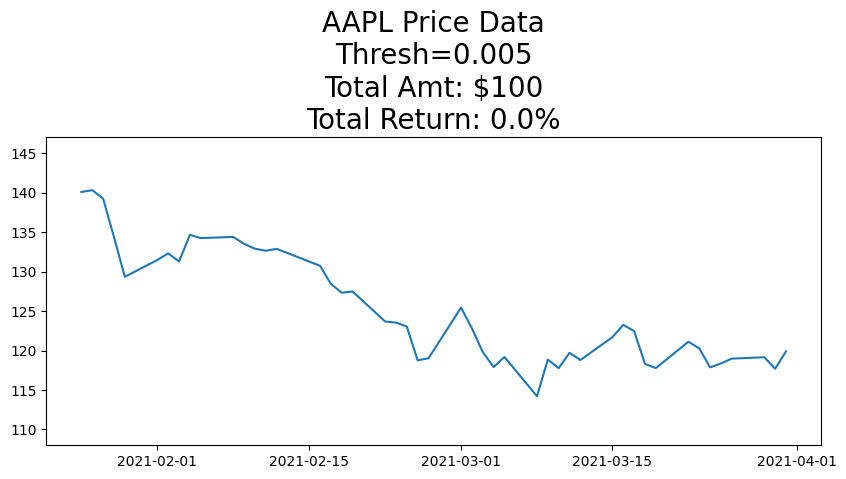

In [15]:
#Trying an AR(5) Model

for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (15,0,0), thresh, verbose=False)